<a href="https://colab.research.google.com/github/MorenoSara/Few-Shot_Text_Classification/blob/main/Weights%26Biases_HPO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# W&B configuarion


In [ ]:
%%capture
!pip install wandb --upgrade

In [ ]:
import wandb

wandb.login()

<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [ ]:
random_seed = 42

In [ ]:
sweep_config = {
    'method': 'bayes'
    }

In [ ]:
metric = {
    'name': 'F1',
    'goal': 'maximize'   
    }

sweep_config['metric'] = metric

In [ ]:
parameters_dict = {
    'optimizer': {
        'values': ['adam', 'sgd']
        },
    }

sweep_config['parameters'] = parameters_dict

In [ ]:
parameters_dict.update({
    'learning_rate': {
        'distribution': 'uniform',
        'min': 1e-6,
        'max': 1e-2
      },
    'training_epochs': {
        'min': 10,
        'max': 40,
      }
    })

In [ ]:
import pprint

pprint.pprint(sweep_config)

{'method': 'bayes',
 'metric': {'goal': 'maximize', 'name': 'F1'},
 'parameters': {'learning_rate': {'distribution': 'uniform',
                                  'max': 0.01,
                                  'min': 1e-06},
                'optimizer': {'values': ['adam', 'sgd']},
                'training_epochs': {'max': 40, 'min': 10}}}


In [ ]:
sweep_id = wandb.sweep(sweep_config, project="ST-raw-few-shots")

# Model and shots section

In [ ]:
!pip install -U sentence-transformers

In [ ]:
import pandas as pd
from sentence_transformers import SentenceTransformer
import torch
from sentence_transformers.util import cos_sim
import numpy as np
import scipy
import random
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
train_dataset = pd.read_excel('/content/drive/MyDrive/WebOfScience datasets/train.xlsx', index_col=0) # 32889 samples
train_dataset.head(10)

,Y1,Y2,Y,Domain,area,keywords,Abstract
0,5,43,115,Medical,Parkinson's Disease,deep brain stimulation; basal ganglia; parkin...,The subthalamic nucleus (STN) and globus palli...
1,0,1,1,CS,Machine learning,Supervised classification; Label ranking prob...,Preference learning is the branch of machine l...
2,0,7,7,CS,Parallel computing,Track fitting; Track reconstruction; Multiple...,Modern semiconductor detectors allow for charg...
3,6,6,131,biochemistry,Polymerase chain reaction,bacterial community; calves; probiotics; rume...,The objective of this study was to assess the ...
4,6,6,131,biochemistry,Polymerase chain reaction,Bladder cancer; glycoprotein nonmetastatic me...,Glycoprotein nonmetastatic melanoma protein B ...
5,3,1,53,MAE,Hydraulics,Groundwater hydraulics; Aquitard; Bangladesh;...,Identifying flow processes in multi-aquifer fl...
6,6,2,127,biochemistry,Human Metabolism,BORON; MANGANESE; MEMBRANES; CELL WALLS; NADH...,Boron has been recognized since 1923 as an ess...
7,2,7,40,Psychology,Depression,putamen; basal ganglia; magnetic resonance im...,Putamen volume is seen to alter in neurologica...
8,0,4,4,CS,Operating systems,Wireless sensor networks; localized interacti...,Wireless sensor networks (WSNs) are characteri...
9,2,4,37,Psychology,Prosocial behavior,Eye contact effects; Therapeutic implications...,Introduction. The perception of a direct gaze ...


In [ ]:
REMAP_LEV1 = {'CS': 'Computer Science', 
              'Civil': 'Civil Engineering', 
              'ECE': 'Electrical Engineering', 
              'Psychology': 'Psychology', 
              'MAE': 'Mechanical Engineering', 
              'Medical': 'Medical Science', 
              'biochemistry': 'Biochemistry'}

In [ ]:
def get_mapped_labels(data, mapping_dict):
  labels = [l.strip() for l in data]
  return list(map(lambda l: mapping_dict[l], labels))

In [ ]:
labels = get_mapped_labels(set(train_dataset['Domain']), REMAP_LEV1)
abstracts = train_dataset['Abstract']

In [ ]:
labels

['Computer Science',
 'Biochemistry',
 'Psychology',
 'Civil Engineering',
 'Medical Science',
 'Electrical Engineering',
 'Mechanical Engineering']

### Compute entropy

In [ ]:
st_model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2', device = device)

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.1k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/363 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.1k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [ ]:
labels_embeddings = st_model.encode(labels)

In [ ]:
# Compute and save the embeddings of the training abstracts
# doc_embeddings = st_model.encode(abstracts, batch_size = 256, show_progress_bar=True) # directly encode the entire documents 
# with open('doc_embeddings.txt','wb') as f:
    # for line in np.matrix(doc_embeddings):
        # np.savetxt(f, line)

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/doc_embeddings.txt', sep = ' ', header=None) 
# retrieve corresponding document using train_dataset.iloc[i]

In [ ]:
def floored_cosine_tensors(X, Y):
  sim = cos_sim(X, Y)
  return np.maximum(0, sim)

In [ ]:
def get_entropies(sentences, labels_embeddings):
  probs = floored_cosine_tensors(sentences, labels_embeddings)
  normalized_probs = probs/np.linalg.norm(probs, axis = 1).reshape(-1,1)
  normalized_entropy = scipy.stats.entropy(normalized_probs, axis = 1)/np.log(labels_embeddings.shape[0])
  print(normalized_entropy.shape)
  return normalized_entropy

In [ ]:
df = df.astype(np.float32)
doc_embeddings = np.asarray(df)
entropies = get_entropies(doc_embeddings, labels_embeddings)

(32889,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in true_divide
  after removing the cwd from sys.path.


In [ ]:
train_df = train_dataset
train_df['Entropy'] = entropies
train_df['Domain'] = get_mapped_labels(train_df['Domain'], REMAP_LEV1)
train_df.dropna(inplace=True)
train_df

,Y1,Y2,Y,Domain,area,keywords,Abstract,Entropy
0,5,43,115,Medical Science,Parkinson's Disease,deep brain stimulation; basal ganglia; parkin...,The subthalamic nucleus (STN) and globus palli...,0.577499
1,0,1,1,Computer Science,Machine learning,Supervised classification; Label ranking prob...,Preference learning is the branch of machine l...,0.784086
2,0,7,7,Computer Science,Parallel computing,Track fitting; Track reconstruction; Multiple...,Modern semiconductor detectors allow for charg...,0.543961
3,6,6,131,Biochemistry,Polymerase chain reaction,bacterial community; calves; probiotics; rume...,The objective of this study was to assess the ...,0.358490
4,6,6,131,Biochemistry,Polymerase chain reaction,Bladder cancer; glycoprotein nonmetastatic me...,Glycoprotein nonmetastatic melanoma protein B ...,0.337900
...,...,...,...,...,...,...,...,...
32884,5,26,98,Medical Science,HIV/AIDS,Biomarkers; Cytokine; HIV; Gingival crevicula...,Objective: This study evaluates the potential ...,0.349118
32885,3,3,55,Mechanical Engineering,Machine design,Red Catuai; Poisson's ratio; density; elastic...,The finite element method has been employed in...,0.766171
32886,2,18,51,Psychology,Problem-solving,health care issues; health care utilization; ...,The University Hospital of Zurich offers a tex...,0.699593
32887,5,41,113,Medical Science,Overactive Bladder,attentional and interoceptive networks; brain...,BACKGROUND: Treatment of urgency urinary incon...,0.828843


Create a dataframe for each label

In [ ]:
dfs = {}
for label in labels:
  dfs[f"{label.replace(' ', '_')}"] = train_df[train_df['Domain'] == label]

In [ ]:
from torch.utils.data.dataset import Dataset
class document_class(Dataset):
  def __init__(self, documents, labels):
    self.train_df = []
    for id, doc in enumerate(documents):
      curr_doc = [labels[id]]
      curr_doc.append(doc) 
      self.train_df.append(curr_doc)
  
  def __getitem__(self, index):
    return self.train_df[index] 

  def __len__(self):
    return len(self.train_df)

In [ ]:
def my_collate_fn(batch):
  documents = []
  labels = []
  for doc in batch:
    documents.append(doc[1])
    labels.append(list(doc[0]))
  return (documents, torch.Tensor(labels))

In [ ]:
def save_model(model, model_path):
    """Save model."""
    torch.save(model.state_dict(), model_path)

def load_model(model, model_path, use_cuda=True):
    """Load model."""
    map_location = 'cpu'
    if use_cuda and torch.cuda.is_available():
        map_location = 'cuda:0'
    model.load_state_dict(torch.load(model_path, map_location))
    return model

In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch
from torch import nn
class TextEncoder(nn.Module):
    def __init__(self, device, model_name: str = 'sentence-transformers/all-mpnet-base-v2') -> None:
        super(TextEncoder, self).__init__()
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name).to(device)

    # def forward(self, text: Union[str, List[str]]) -> Tensor:
    def forward(self, text) -> torch.Tensor:
        inp = self.tokenizer(text, padding=True, truncation=True, return_tensors='pt')
        inp = inp.to(device)
        out = self.model(**inp)[0]  # First element of model_output contains all token embeddings.
        out = self.mean_pooling(out, inp['attention_mask'])
        if isinstance(text, str):  # If input is just 1 string -> return 1D embeddings.
            out = out.squeeze(0)
        return nn.functional.normalize(out, p=2, dim=-1)

    def mean_pooling(self, token_embeddings, attention_mask):
        input_mask_expanded = \
            attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
        return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

In [ ]:
class complete_model_finetuning(nn.Module):
  def __init__(self, sentence_transformer_model, st_embedding_dimension, num_classes, device):
    super().__init__()
    self.st = TextEncoder(device, sentence_transformer_model)
    self.device = device
    self.to(device)

  def forward(self, documents):
    docs = self.st(documents) # assign a score to each class for every document
    return docs

### $\alpha Entropy+ (1-\alpha) Distance$

In [ ]:
def tradeoff(dfs, N_shots, alpha = 0.7, threshold = 0.8):
  N_shots_data = []

  for k in dfs.keys(): # for each dataframe containing the documents relative to a single label
    if len(dfs[k]) > 0: # if the dataframe has at least an entry

      ordered = dfs[k].iloc[(dfs[k]['Entropy']).argsort()[::-1].values] # sort the values according to their entropy 
      ordered = ordered[ordered['Entropy'] <= threshold][:N_shots*2] 
      #ordered_embeddings = st_model.encode(list(ordered['Abstract']), batch_size = 256, show_progress_bar=True) # compute the documents embeddings
      ordered_embeddings = doc_embeddings[ordered.index]

      N_shots_embeddings = [] # list successively used to compute the centroid

      for i in range(N_shots): 

        if i == 0: # select the document with the highest entropy
          first = ordered.iloc[0] # the first element has the highest entropy
          N_shots_data.append(pd.DataFrame.from_records([first.to_dict()])) # save the data of the document
          N_shots_embeddings.append(ordered_embeddings[0])
          ordered.drop(ordered.index[0], inplace=True) # drop the row corresponding to the element with the higest entropy for the successive iterations
          ordered['aE+(1-a)D'] = alpha * ordered['Entropy']+(1-alpha)*np.linalg.norm(ordered_embeddings[0]-ordered_embeddings[1:], axis = 1) # alpha * Entropy + (1 - alpha) Euclidean_distance(highest_entropy - all_other_points)
          ordered_embeddings = ordered_embeddings[1:] # drop the embedding corresponding to the element with the higest entropy for the successive iterations
          continue # go to the second point

        first_id = np.argmax(ordered['aE+(1-a)D']) # retrieve the id of the documnet with the highest alpha * Entropy + (1-alpha)distance
        first = ordered.iloc[first_id] # get the corresponding document
        N_shots_embeddings.append(ordered_embeddings[first_id]) # append in the list its embeddings
        centroid = np.mean(N_shots_embeddings, axis=0) # compute the centroid of the documente selected so far
        ordered.drop(ordered.index[first_id], inplace=True) # remove the document from the dataframe
        ordered_embeddings = np.delete(ordered_embeddings, first_id, 0) # remove its embedding
        ordered['aE+(1-a)D'] = alpha * ordered['Entropy']+(1-alpha)*np.linalg.norm(centroid-ordered_embeddings, axis = 1) # alpha * Entropy + (1-alpha)Euclidean_distance(centroid - remaining_points)
        top = pd.DataFrame.from_records([ordered.iloc[np.argmax(ordered['aE+(1-a)D'])].to_dict()]) # retrieve the data of the document with the highest Entropy+Distance
        N_shots_data.append(top) # save it
        
  dataframes = pd.concat(N_shots_data).reset_index(drop=True) # input of concat is a list of dataframes
  return dataframes

### Medoids

In [ ]:
from sklearn.cluster import KMeans
from scipy.cluster.vq import vq

def medoids(doc_embeddings, N_shots):
  kmeans = KMeans(n_clusters = N_shots * len(labels))
  kmeans.fit(doc_embeddings)
  centroids = np.array(kmeans.cluster_centers_) # retrieve centroids
  closest, _ = vq(centroids, doc_embeddings) # selects the indices of the centroids' nearest documents

  dataframes = train_dataset.iloc[closest]
  return dataframes.reset_index(drop=True)

### Loss

In [ ]:
from torch import Tensor, sum, exp, mm, bmm, nn
class NContrastiveLoss(nn.Module):
    '''
    Compute generalised Contrastive Loss, where there is 1 positive and N negative labels
    for each instance. The embedding of the instance gets pulled close to the positive
    label embedding while being pushed away from each of the N negative labels embeddings.
    https://papers.nips.cc/paper/2016/hash/6b180037abbebea991d8b1232f8a8ca9-Abstract.html
    '''
    def __init__(self) -> None:
        super(NContrastiveLoss, self).__init__()

    def forward(self, anchor: Tensor, positive: Tensor, negatives: Tensor) -> torch.float:
        '''
        Pulls anchor and positive closer together and pushes anchor and negatives further
        apart.
        For each example in the batch, there is 1 anchor, 1 positive and N negatives.
        The loss formulated here optimizes the dot product.

        Parameters
        ----------
        anchor: 2D tensor
                batch of anchors embeddings
        positive: 2D tensor
                  batch of positive embedding
        negatives : 3D tensor
                    batch of N-negatives embeddings per

        Returns
        -------
        Float tensor
            Sum of N-contrastive-loss for each element of the batch.
        '''
        # Make anchor and positive tensors 3D, by expanding empty dimension 1.
        batch_size = len(anchor)
        anchor = anchor.unsqueeze(1)
        positive = positive.unsqueeze(1)
        # Compute loss.
        A = exp(bmm(anchor, positive.transpose(2, 1))).view(batch_size)
        B = sum(exp(bmm(anchor, negatives.transpose(2, 1)).squeeze(1)), dim=-1)
        return -sum(torch.log(A / (A + B)), dim=-1) / batch_size

In [ ]:
def floored_cosine_knn(x, y):
  norm_x = x/np.linalg.norm(x)
  norm_y = y/np.linalg.norm(y)
  return max(0.0, 1 - np.dot(norm_x, norm_y))

# Test and eval

In [ ]:
test_dataset = pd.read_excel('/content/drive/MyDrive/WebOfScience datasets/test.xlsx', index_col=0)
test_docs = test_dataset['Abstract']
test_labels = get_mapped_labels(test_dataset['Domain'], REMAP_LEV1)

In [ ]:
eval_dataset = pd.read_excel('/content/drive/MyDrive/WebOfScience datasets/valid.xlsx', index_col=0)
eval_docs = eval_dataset['Abstract']
eval_labels = get_mapped_labels(eval_dataset['Domain'], REMAP_LEV1)

In [ ]:
import random
random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
if device == 'cuda':
  torch.cuda.set_device(gpu_no)
  torch.cuda.manual_seed(random_seed)
eval_ids = random.sample(range(0, len(eval_dataset)), 100)
eval_ids = sorted(eval_ids)

# W&D selcetion

In [ ]:
dataframes = tradeoff(dfs, 1)
dataframes

,Y1,Y2,Y,Domain,area,keywords,Abstract,Entropy
0,2,0,33,Psychology,Prejudice,highly skilled labor migration; Sweden; Japan...,"As labor markets become increasingly global, c...",0.799836
1,4,9,70,Civil Engineering,Construction Management,Construction management; Health hazards; Cons...,A theory-based intervention strategy to improv...,0.799878
2,5,9,81,Medical Science,Skin Care,Early mobility in intensive care unit; Mobili...,BACKGROUND: Pressure ulcer formation continues...,0.799966
3,1,13,30,Electrical Engineering,State space representation,Fuzzy transform; Concentrated solar collector...,This paper deals with the control of concentra...,0.799784
4,3,1,53,Mechanical Engineering,Hydraulics,fine roots; native embolism; refilling; starc...,Restoration of an adequate water supply in spr...,0.799582
5,6,3,128,Biochemistry,Immunology,time-delay; cancer immunotherapy; gene-regula...,"In this paper, we analyse the local stability ...",0.798928
6,0,7,7,Computer Science,Parallel computing,Fast fuzzy c-means algorithm; Image segmentat...,The research on underwater image segmentation ...,0.799874


In [ ]:
def build_optimizer(network, optimizer, learning_rate):
    if optimizer == "sgd":
        optimizer = optim.SGD(filter(lambda p: p.requires_grad, network.parameters()),
                              lr=learning_rate, 
                              momentum=0.9)
    elif optimizer == "adam":
        optimizer = optim.Adam(filter(lambda p: p.requires_grad, network.parameters()), 
                               lr=learning_rate, 
                               betas = [0.9, 0.999], 
                               eps=1e-8)
    return optimizer


def train_epoch(network, loader, optimizer, criterion):
  training_loss = 0

  network.train()

  for batch, (training_labels, docs) in enumerate(loader):
    labels_set = list(labels)
    labels_encoding = network(labels_set)
    lab2emb = dict(zip(labels_set, labels_encoding))
    negatives_list = []
    positive_list = []
    for positive in training_labels:
      x = [v for k, v in lab2emb.items() if not k == positive]
      pos = [v for k, v in lab2emb.items() if k == positive]
      negatives_list.append(torch.stack(x))
      positive_list.extend(pos)
    negatives = torch.stack(negatives_list)
    positives = torch.stack(positive_list)
    negatives = negatives.to(device)
    positives = positives.to(device)
    document_embeddings = network(list(docs))
    loss = criterion(document_embeddings, positives, negatives)
    optimizer.zero_grad()
    loss.backward()
    training_loss += loss
    optimizer.step()

    wandb.log({"batch loss": loss.item()})


In [ ]:
import torch
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train(config=None):
    # Initialize a new wandb run
    with wandb.init(config=config):
        # If called by wandb.agent, as below,
        # this config will be set by Sweep Controller
        config = wandb.config
        training_documents = document_class(dataframes['Abstract'], dataframes['Domain'])
        loader = DataLoader(training_documents, batch_size=8, shuffle=True)
        network = complete_model_finetuning('sentence-transformers/all-mpnet-base-v2', 768, 768, device)
        optimizer = build_optimizer(network, config.optimizer, config.learning_rate)
        criterion = NContrastiveLoss()

        for epoch in range(config.training_epochs):

            random.seed(random_seed)
            np.random.seed(random_seed)
            torch.manual_seed(random_seed)
            if device == 'cuda':
              torch.cuda.set_device(gpu_no)
              torch.cuda.manual_seed(random_seed)
              
            avg_loss = train_epoch(network, loader, optimizer, criterion)
            network.eval()
            tmp_test_document_embeddings = []

            with torch.no_grad():
              label_embeddings = network(labels)

            test_dataloader = DataLoader(list(eval_docs.iloc[eval_ids]), batch_size=32, shuffle=False)
            for test_doc in tqdm(test_dataloader):
              with torch.no_grad():
                embs = network(test_doc)
              tmp_test_document_embeddings.extend(embs)

            test_document_embeddings = torch.stack(tmp_test_document_embeddings)
            knn = KNeighborsClassifier(n_neighbors=1, algorithm = 'brute', metric = floored_cosine_knn)
            knn.fit(label_embeddings.cpu(), labels)
            y_pred = knn.predict(test_document_embeddings.cpu())
            selected_elements = [eval_labels[index] for index in eval_ids]
            F1 = f1_score(selected_elements, y_pred, average='macro')
            wandb.log({"F1": F1, "epoch": epoch})           

In [ ]:
wandb.agent(sweep_id, train, count=5)

wandb: Agent Starting Run: ozvznjc1 with config:
wandb: 	learning_rate: 0.00674492302637839
wandb: 	optimizer: adam
wandb: 	training_epochs: 21


Downloading:   0%|          | 0.00/363 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/418M [00:00<?, ?B/s]

100%|██████████| 4/4 [00:03<00:00,  1.31it/s]


F1,▅▁▁▁▁▄▁▁▁▁▂▁▁▁▁▁▁█▁▁▁
batch loss,▁█▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆
epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
F1,0.02883
batch loss,1.94592
epoch,20


wandb: Agent Starting Run: 58gomxb7 with config:
wandb: 	learning_rate: 0.001839107807763036
wandb: 	optimizer: adam
wandb: 	training_epochs: 39


100%|██████████| 4/4 [00:03<00:00,  1.26it/s]


F1,▂▁▃▅▃▁▁▁▂▄▁█▅▅▄▁▁▂▁▁▁▁▁▁▂▁▁▂▃▁▂▂▂▁▁▁▃▁▅
batch loss,▁▇█▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
F1,0.09003
batch loss,1.94587
epoch,38


wandb: Agent Starting Run: z7atkq2r with config:
wandb: 	learning_rate: 0.000742039436958882
wandb: 	optimizer: sgd
wandb: 	training_epochs: 40


100%|██████████| 4/4 [00:03<00:00,  1.21it/s]


F1,▁▁▁▁▁▁▂▂▂▂▂▂▂▃▅▅▅▅▅▅▅▅▅▅▅▆▆████▇▇▇▇▇▇▆▆▆
batch loss,███▇██▇▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▁▁▁
epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
F1,0.7455
batch loss,1.57341
epoch,39


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 9533omsa with config:
wandb: 	learning_rate: 0.0022750603155825876
wandb: 	optimizer: sgd
wandb: 	training_epochs: 20


100%|██████████| 4/4 [00:03<00:00,  1.23it/s]


F1,▁▁▁▁▂▂▂▅▅▄▄▅▆█▇▇▆▆▄▄
batch loss,███▇▇▇▆▆▆▆▅▅▄▄▃▃▂▂▁▁
epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
F1,0.71028
batch loss,1.55027
epoch,19


wandb: Agent Starting Run: mzaqlnz5 with config:
wandb: 	learning_rate: 0.0015439259951453635
wandb: 	optimizer: sgd
wandb: 	training_epochs: 15


100%|██████████| 4/4 [00:03<00:00,  1.23it/s]


F1,▁▁▁▁▂▃▃▃▃▇▇▆▆▆█
batch loss,███▆▇▇▆▅▅▅▄▃▃▂▁
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
F1,0.72853
batch loss,1.71585
epoch,14


# Test selected parameters


In [ ]:
# select 2000 random test documents
random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
if device == 'cuda':
  torch.cuda.set_device(gpu_no)
  torch.cuda.manual_seed(random_seed)
test_ids_2000 = random.sample(range(0, len(test_dataset)), 2000)
test_ids_2000 = sorted(test_ids_2000)

In [ ]:
random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
if device == 'cuda':
  torch.cuda.set_device(gpu_no)
  torch.cuda.manual_seed(random_seed)
#dataframes = tradeoff(dfs, 1)
dataframes = medoids(doc_embeddings, 12)
dataframes

,Y1,Y2,Y,Domain,area,keywords,Abstract,Entropy
0,5,20,92,Medical Science,Fungal Infection,adrenal; cryptococcosis; F-18-FDG PET/CT,"Cryptococcosis is a fungal infection, relative...",0.356117
1,0,13,13,Computer Science,Algorithm design,Generalized spatial modulation (GSM); maximum...,Generalized spatial modulation (GSM) is a spec...,0.356197
2,3,5,57,Mechanical Engineering,Internal combustion engine,Distribution network; PHEVs charging station ...,"Recently, plug-in hybrid electric vehicles (PH...",0.608467
3,0,6,6,Computer Science,Image processing,Hyperspectral remote sensing images; content-...,With the rapid development of remote sensing t...,0.789938
4,5,20,92,Medical Science,Fungal Infection,neurodegenerative disease; fungal infection; ...,Recent findings provide evidence that fungal s...,0.414066
...,...,...,...,...,...,...,...,...
79,5,42,114,Medical Science,Parenting,Callous-unemotional; parenting; psychopathy; ...,BackgroundCallous-unemotional behaviors identi...,0.076575
80,0,9,9,Computer Science,Software engineering,Search-based software engineering (SBSE); Mod...,Model-driven engineering (MDE) and search-base...,0.770524
81,5,10,82,Medical Science,Bipolar Disorder,cognitive remediation; depression; schizophre...,Objective: This study explored whether age mod...,0.308985
82,4,1,62,Civil Engineering,Geotextile,low-crested breakwaters; geotextile tube; bea...,"Sigandu is a coastal tourism area, which is lo...",0.710342


In [ ]:
import torch.optim as optim
from torch.utils.data import DataLoader

random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
if device == 'cuda':
  torch.cuda.set_device(gpu_no)
  torch.cuda.manual_seed(random_seed)

finetuned_model = complete_model_finetuning('sentence-transformers/all-mpnet-base-v2', 768, 768, device)
lr = 0.00003719
epochs = 4
batch_size = 8

criterion = NContrastiveLoss()

optimizer = optim.Adam(filter(lambda p: p.requires_grad, finetuned_model.parameters()), lr=lr, betas = [0.9, 0.999], eps=1e-8)
                              
#optimizer = optim.SGD(filter(lambda p: p.requires_grad, finetuned_model.parameters()), lr=lr, momentum=0.9)

training_documents = document_class(dataframes['Abstract'], dataframes['Domain'])
training_dataloader = DataLoader(training_documents, batch_size=batch_size, shuffle=True)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
from tqdm import tqdm
best_eval_loss = np.inf

for epoch in range(epochs):

  training_loss = 0

  finetuned_model.train()

  for batch, (training_labels, docs) in enumerate(training_dataloader):
    labels_set = list(labels)
    labels_encoding = finetuned_model(labels_set)
    lab2emb = dict(zip(labels_set, labels_encoding))
    negatives_list = []
    positive_list = []
    for positive in training_labels:
      x = [v for k, v in lab2emb.items() if not k == positive]
      pos = [v for k, v in lab2emb.items() if k == positive]
      negatives_list.append(torch.stack(x))
      positive_list.extend(pos)
    negatives = torch.stack(negatives_list)
    positives = torch.stack(positive_list)
    negatives = negatives.to(device)
    positives = positives.to(device)
    document_embeddings = finetuned_model(list(docs))
    loss = criterion(document_embeddings, positives, negatives)
    optimizer.zero_grad()
    loss.backward()
    training_loss += loss
    optimizer.step()

    print(f'Batch: {batch+1}/{len(training_dataloader)}, epoch: {epoch+1}/{epochs}. Training loss: {training_loss:.3f}.')

finetuned_model.eval()
tmp_test_document_embeddings = []

with torch.no_grad():
  label_embeddings = finetuned_model(labels)

test_dataloader = DataLoader(list(test_docs.iloc[test_ids_2000]), batch_size=32, shuffle=False)
for test_doc in tqdm(test_dataloader):
  with torch.no_grad():
    embs = finetuned_model(test_doc)
  tmp_test_document_embeddings.extend(embs)

test_document_embeddings = torch.stack(tmp_test_document_embeddings)
knn = KNeighborsClassifier(n_neighbors=1, algorithm = 'brute', metric = floored_cosine_knn)
knn.fit(label_embeddings.cpu(), labels)
y_pred = knn.predict(test_document_embeddings.cpu())
selected_elements = [test_labels[index] for index in test_ids_2000]
F1 = f1_score(selected_elements, y_pred, average='macro')
print(f'Epoch: {epoch+1}, F1 macro: {F1}')

Batch: 1/35, epoch: 1/4. Training loss: 1.808.
Batch: 2/35, epoch: 1/4. Training loss: 3.672.
Batch: 3/35, epoch: 1/4. Training loss: 5.423.
Batch: 4/35, epoch: 1/4. Training loss: 7.148.
Batch: 5/35, epoch: 1/4. Training loss: 8.868.
Batch: 6/35, epoch: 1/4. Training loss: 10.529.
Batch: 7/35, epoch: 1/4. Training loss: 12.107.
Batch: 8/35, epoch: 1/4. Training loss: 13.739.
Batch: 9/35, epoch: 1/4. Training loss: 15.350.
Batch: 10/35, epoch: 1/4. Training loss: 16.792.
Batch: 11/35, epoch: 1/4. Training loss: 18.203.
Batch: 12/35, epoch: 1/4. Training loss: 19.638.
Batch: 13/35, epoch: 1/4. Training loss: 20.958.
Batch: 14/35, epoch: 1/4. Training loss: 22.538.
Batch: 15/35, epoch: 1/4. Training loss: 24.025.
Batch: 16/35, epoch: 1/4. Training loss: 25.713.
Batch: 17/35, epoch: 1/4. Training loss: 27.329.
Batch: 18/35, epoch: 1/4. Training loss: 28.695.
Batch: 19/35, epoch: 1/4. Training loss: 30.123.
Batch: 20/35, epoch: 1/4. Training loss: 31.590.
Batch: 21/35, epoch: 1/4. Training

100%|██████████| 63/63 [01:04<00:00,  1.03s/it]


Epoch: 4, F1 macro: 0.7018137382816135


In [ ]:
# set a fixed label order to be consistent with the following images
labels = ["Mechanical Engineering", "Biochemistry", "Civil Engineering", "Computer Science", "Medical Science", "Electrical Engineering", "Psychology"]

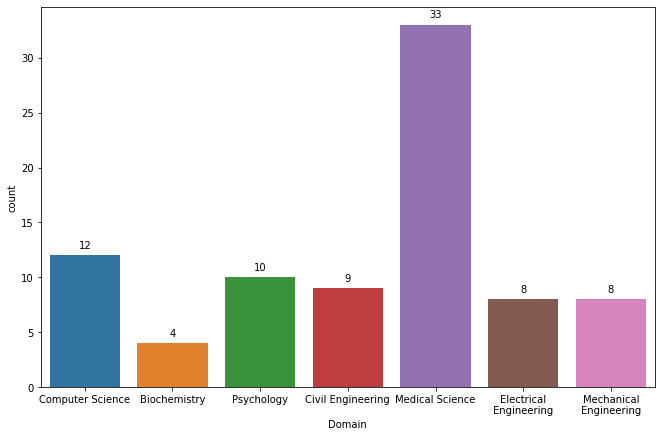

In [ ]:
import matplotlib.pyplot as plt
from pandas.core.dtypes.inference import is_number
from textwrap import wrap
import seaborn as sns
plt.figure(figsize=(11,7))
df_plot = dataframes.copy(deep=True)
df_plot['Domain'] = [ '\n'.join(wrap(l, 20)) for l in df_plot['Domain'] ]
ax = sns.countplot(x="Domain", data=df_plot, order = [ '\n'.join(wrap(l, 17)) for l in labels])
for p in ax.patches:
  if not np.isnan(p.get_height()):
    ax.annotate(format(int(p.get_height()), 'd'), (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
  else:
    ax.annotate(0, (p.get_x() + p.get_width() / 2., 0), ha='center', va='center', xytext=(0, 10), textcoords='offset points')
plt.savefig('cluster_12shot_distribution.eps', format='eps')

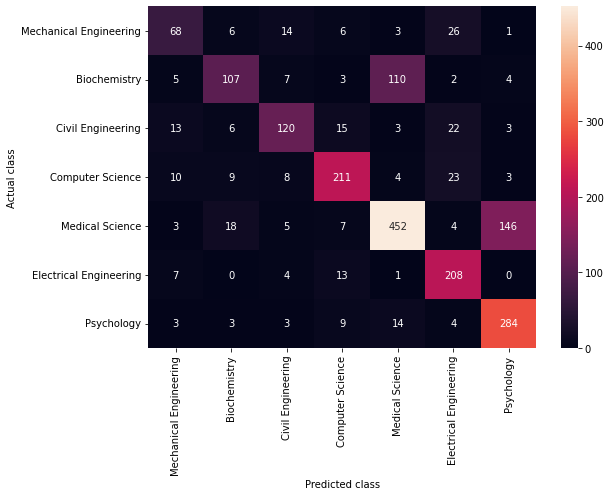

In [ ]:
# Compute the confusion matrix for the results obtained by ST-raw
from sklearn.metrics import confusion_matrix
plt.figure(figsize=(9,7))
cm = confusion_matrix(selected_elements, y_pred, labels=labels)
cm_df = pd.DataFrame(data = cm, index =labels, columns =labels)
ax = sns.heatmap(cm_df, annot=True, fmt = 'd') # with 'Engineering'
ax.set_xlabel("Predicted class")
ax.set_ylabel("Actual class")
plt.tight_layout()
plt.savefig('cluster_40shot.eps', format='eps')

# Compare results with ST-C

In [ ]:
from torch import nn
class Classifier(nn.Module):
  def __init__(self, in_dim, out_dim, device, dropout = 0.3):
    super().__init__()
    self.classification = nn.Linear(in_features=in_dim, out_features=out_dim)
    torch.nn.init.eye_(self.classification.weight)
    torch.nn.init.zeros_(self.classification.bias)
    self.device = device
    self.dropout = nn.Dropout(dropout)
    self.to(device)

  def forward(self, documents_embeddings):
    docs = self.dropout(documents_embeddings)
    scores = self.classification(docs) # assign a score to each class for every document
    return scores

Retrieve test embeddings

In [ ]:
test_embeddings = pd.read_csv('/content/drive/MyDrive/test_embeddings.txt', sep = ' ', header=None)

test_embeddings = test_embeddings.astype(np.float32)
test_embeddings = np.asarray(test_embeddings)
test_embeddings = [test_embeddings[index] for index in test_ids_2000]

In [ ]:
import torch.optim as optim
from torch.utils.data import DataLoader

random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
if device == 'cuda':
  torch.cuda.set_device(gpu_no)
  torch.cuda.manual_seed(random_seed)
classifier_unsupervised = Classifier(768, 768, device)

lr = 1e-2
epochs = 3
batch_size = 256

criterion = NContrastiveLoss()
optimizer = optim.Adam(filter(lambda p: p.requires_grad, classifier_unsupervised.parameters()), lr=lr, betas = [0.9, 0.999], eps=1e-8)
model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2', device = device)
documents_emb = model.encode(dataframes['Abstract'], convert_to_tensor=True)
lab_embeddings = model.encode(labels, convert_to_tensor=True)
labels_encoding = model.encode(labels, convert_to_tensor=True)
lab2emb = dict(zip(labels, labels_encoding))

documents = tuple(zip(dataframes['Domain'], np.asarray(documents_emb.cpu())))
training_dataloader = DataLoader(documents, batch_size=batch_size, shuffle=True)


In [ ]:
from torch.utils.tensorboard import SummaryWriter
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
from tqdm import tqdm
writer = SummaryWriter()
best_eval_loss = np.inf
for epoch in range(epochs):

  training_loss = 0

  classifier_unsupervised.train()

  for batch, (training_labels, docs) in enumerate(training_dataloader):
    encoded_labs = classifier_unsupervised(lab_embeddings)
    lab2emb = dict(zip(labels, encoded_labs))
    docs = docs.to(device)
    negatives_list = []
    positive_list = []
    for positive in training_labels:
      x = [v for k, v in lab2emb.items() if not k == positive]
      pos = [v for k, v in lab2emb.items() if k == positive]
      negatives_list.append(torch.stack(x))
      positive_list.extend(pos)
    negatives = torch.stack(negatives_list)
    positives = torch.stack(positive_list)
    negatives = negatives.to(device)
    positives = positives.to(device)
    document_embeddings = classifier_unsupervised(docs)
    loss = criterion(document_embeddings, positives, negatives)
    optimizer.zero_grad()
    loss.backward()
    training_loss += loss
    optimizer.step()

    print(f'Batch: {batch}/{len(training_dataloader)}, epoch: {epoch}/{epochs}. Training loss: {training_loss:.3f}.')
    writer.add_scalar("Loss/epoch", training_loss, epoch+1)

    classifier_unsupervised.eval()
    test_document_embeddings = []

    with torch.no_grad():
      label_embeddings = classifier_unsupervised(lab_embeddings)

    test_dataloader = DataLoader(test_embeddings, batch_size=256, shuffle=False)
    for test_docums in test_dataloader:
      with torch.no_grad():
        test_docums = test_docums.to(device)
        embs = classifier_unsupervised(test_docums)
      test_document_embeddings.extend(embs)

    test_document_embeddings = torch.stack(test_document_embeddings)
    knn = KNeighborsClassifier(n_neighbors=1, algorithm = 'brute', metric = floored_cosine_knn)
    knn.fit(label_embeddings.cpu(), labels)
    y_pred = knn.predict(test_document_embeddings.cpu())
    test_lab = [test_labels[index] for index in test_ids_2000]
    F1 = f1_score(test_lab, y_pred, average='macro')
    print(f'Epoch: {epoch}, F1 macro: {F1}')

    writer.add_scalar("F1_macro/epoch", F1, epoch+1)

writer.flush()

Batch: 0/1, epoch: 0/3. Training loss: 1.821.
Epoch: 0, F1 macro: 0.669448978449978
Batch: 0/1, epoch: 1/3. Training loss: 0.797.
Epoch: 1, F1 macro: 0.6537913391405331
Batch: 0/1, epoch: 2/3. Training loss: 0.579.
Epoch: 2, F1 macro: 0.6757609904344505


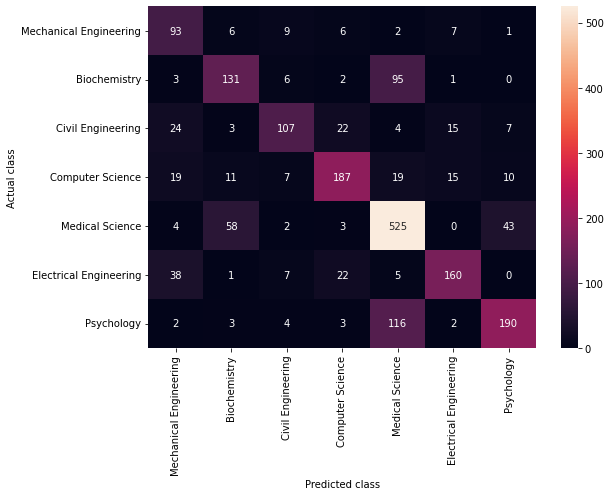

In [ ]:
from sklearn.metrics import confusion_matrix
plt.figure(figsize=(9,7))
cm = confusion_matrix(test_lab, y_pred, labels=labels)
cm_df = pd.DataFrame(data = cm, index =labels, columns =labels)
ax = sns.heatmap(cm_df, annot=True, fmt = 'd') # with 'Engineering'
ax.set_xlabel("Predicted class")
ax.set_ylabel("Actual class")
plt.tight_layout()
plt.savefig('cluster_12shot_cl.eps', format='eps')

In [ ]:
shots = [1,3,6,9,12,15,27,40]
wandb_results = [0.6693275019246148, 0.6665355015540825, 0.670980181753486, 0.674684878452179, 0.6743425240376385, 0.675843093679913, 0.698789558444304, 0.6774280019060813]
learning_rates = [0.008997, 0.007433, 0.0004216, 0.0003084, 0.00001103, 0.00004738, 0.00004763, 0.00003719]
selected_training_epochs = [7, 4, 17, 12, 1, 30, 20, 7]